# Fáza 2

**Michaela Gubovská, Jakub Hajdu**

V tejto fáze zealizujeme predspracovanie údajov pre strojové učenie.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.stats.api as sms
import numpy as np
import category_encoders as ce
from datetime import datetime
from sklearn.impute import SimpleImputer, KNNImputer
from copy import deepcopy

filename_p = "data/profiles.csv"
dfp = pd.read_csv(filename_p, sep='\t')

filename_l = "data/labor.csv"
dfl = pd.read_csv(filename_l, sep='\t')

Pôvodné neočistené dáta vyzerajú napríklad nasledovne:

In [2]:
dfp.head()

,Unnamed: 0,job,address,blood_group,ssn,birthdate,residence,race,name,sex
0,0,Quarry manager,"6269 Kelsey Cove\nJessicahaven, KY 76299",B+,818-49-6074,1925-12-31,"30070 Anderson Branch Suite 371\nHoffmanberg, ...",White,Kimberly Frazier,F
1,1,Financial risk analyst,"72241 Luna Divide Suite 877\nMelindachester, I...",B+,617-52-9894,"03/21/1912, 00:00:00","61551 Williams Shoal Apt. 506\nLunaborough, VA...",Black,Timothy Gutierrez MD,M
2,2,Waste management officer,"6554 Nicole Lodge\nNorth Tanner, PA 59584",B+,690-88-6942,1960-11-19,"77305 Palmer Valleys Suite 424\nJennifertown, ...",Black,Elaine Elliott,F
3,3,Publishing rights manager,"847 Taylor Court Apt. 547\nGutierrezfort, SD 1...",O+,767-13-0171,1978/11/14,"62021 Schwartz Roads\nJaimeville, SD 64413",Black,Richard Anderson,M
4,4,Medical sales representative,"83815 Richard Causeway Suite 275\nLemouth, WV ...",B+,412-57-1910,"03/14/1995, 00:00:00",Unit 4872 Box 1158\nDPO AA 51410,white,Jennifer Bass,F


In [3]:
dfl.head()

,Unnamed: 0,leukocyty,ssn,name,smoker,hemoglobin,trombocyty,indicator,alt,relationship,weight,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty
0,0,5.90289,513-95-7625,Andrew Jacobs,no,7.54279,5.83096,1.0,17.60670,widowed,8.09544,42.92870,60.77098,6.50802,5.54259,6.57020,47.78400,5.46395
1,1,5.56403,025-71-2115,Ian Harrison,Y,7.87747,NaN,1.0,17.78037,single,73.58725,50.25507,47.14780,3.49169,3.52227,4.82276,55.62479,5.37924
2,2,6.24057,824-63-0108,Matthew Williams,no,4.72650,7.83234,1.0,25.25152,single,129.45079,25.15943,48.53570,8.65913,8.25976,5.64422,48.44629,6.52365
3,3,5.48374,157-32-2908,Charles Chavez,no,5.43079,5.36911,1.0,18.32802,divoced,18.61698,45.02094,73.77687,9.30190,6.26535,6.23014,50.48872,4.33766
4,4,6.04784,545-96-1267,Allen Chung MD,yes,8.85943,6.76682,1.0,11.03841,divoced,78.83355,59.06392,17.65112,4.47835,2.28488,7.83874,38.74892,5.17704


Ako prvé vykonáme základné úpravy dát z prvej fázy (EDA). Konkrétne očistíme tabuľky od nepotrebného stĺpca "Unnamed", zjednotíme hodnoty vo vybraných stĺpcoch (yes/no a pod.), upravíme stĺpec "birthdate" na iba rok narodenia a odstránime duplikáty z druhej tabuľky, nakoľko z EDA vieme, že v prvej sa duplikáty nenachádzajú.

In [4]:
dfp.drop('Unnamed: 0', axis=1, inplace=True)
dfp['race'] = dfp['race'].str.replace('white','White')
dfp['race'] = dfp['race'].str.replace('black','Black')
dfp['race'] = dfp['race'].str.replace('blsck','Black')
dfp['birthdate'] = (pd.to_datetime(dfp.birthdate)).dt.year


dfl.drop('Unnamed: 0', axis=1, inplace=True)
dfl = dfl.drop_duplicates()
dfl['smoker'] = dfl['smoker'].str.replace('N','no')
dfl['smoker'] = dfl['smoker'].str.replace('Y','yes')

Po týchto úpravách už vyzerajú naše dáta takto:

In [5]:
dfp.head()

,job,address,blood_group,ssn,birthdate,residence,race,name,sex
0,Quarry manager,"6269 Kelsey Cove\nJessicahaven, KY 76299",B+,818-49-6074,1925,"30070 Anderson Branch Suite 371\nHoffmanberg, ...",White,Kimberly Frazier,F
1,Financial risk analyst,"72241 Luna Divide Suite 877\nMelindachester, I...",B+,617-52-9894,1912,"61551 Williams Shoal Apt. 506\nLunaborough, VA...",Black,Timothy Gutierrez MD,M
2,Waste management officer,"6554 Nicole Lodge\nNorth Tanner, PA 59584",B+,690-88-6942,1960,"77305 Palmer Valleys Suite 424\nJennifertown, ...",Black,Elaine Elliott,F
3,Publishing rights manager,"847 Taylor Court Apt. 547\nGutierrezfort, SD 1...",O+,767-13-0171,1978,"62021 Schwartz Roads\nJaimeville, SD 64413",Black,Richard Anderson,M
4,Medical sales representative,"83815 Richard Causeway Suite 275\nLemouth, WV ...",B+,412-57-1910,1995,Unit 4872 Box 1158\nDPO AA 51410,White,Jennifer Bass,F


In [6]:
dfl.head()

,leukocyty,ssn,name,smoker,hemoglobin,trombocyty,indicator,alt,relationship,weight,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty
0,5.90289,513-95-7625,Andrew Jacobs,no,7.54279,5.83096,1.0,17.60670,widowed,8.09544,42.92870,60.77098,6.50802,5.54259,6.57020,47.78400,5.46395
1,5.56403,025-71-2115,Ian Harrison,yes,7.87747,NaN,1.0,17.78037,single,73.58725,50.25507,47.14780,3.49169,3.52227,4.82276,55.62479,5.37924
2,6.24057,824-63-0108,Matthew Williams,no,4.72650,7.83234,1.0,25.25152,single,129.45079,25.15943,48.53570,8.65913,8.25976,5.64422,48.44629,6.52365
3,5.48374,157-32-2908,Charles Chavez,no,5.43079,5.36911,1.0,18.32802,divoced,18.61698,45.02094,73.77687,9.30190,6.26535,6.23014,50.48872,4.33766
4,6.04784,545-96-1267,Allen Chung MD,yes,8.85943,6.76682,1.0,11.03841,divoced,78.83355,59.06392,17.65112,4.47835,2.28488,7.83874,38.74892,5.17704


Pre ďalšie úpravy dát si tieto 2 tabuľky spojíme do jednej.

In [7]:
df = pd.merge(dfp, dfl, how="left", on=["ssn"])
df.head()

,job,address,blood_group,ssn,birthdate,residence,race,name_x,sex,leukocyty,...,alt,relationship,weight,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty
0,Quarry manager,"6269 Kelsey Cove\nJessicahaven, KY 76299",B+,818-49-6074,1925,"30070 Anderson Branch Suite 371\nHoffmanberg, ...",White,Kimberly Frazier,F,6.35996,...,16.37812,widowed,51.36819,43.29070,70.74271,7.45522,6.08021,5.85295,39.27380,4.42627
1,Quarry manager,"6269 Kelsey Cove\nJessicahaven, KY 76299",B+,818-49-6074,1925,"30070 Anderson Branch Suite 371\nHoffmanberg, ...",White,Kimberly Frazier,F,6.11726,...,16.43658,married,29.84194,28.92169,82.95045,4.53835,6.37624,7.37613,46.09380,4.43045
2,Quarry manager,"6269 Kelsey Cove\nJessicahaven, KY 76299",B+,818-49-6074,1925,"30070 Anderson Branch Suite 371\nHoffmanberg, ...",White,Kimberly Frazier,F,6.65582,...,15.94319,married,122.71392,46.08027,23.47025,4.54148,7.61836,6.73630,54.74172,5.24299
3,Quarry manager,"6269 Kelsey Cove\nJessicahaven, KY 76299",B+,818-49-6074,1925,"30070 Anderson Branch Suite 371\nHoffmanberg, ...",White,Kimberly Frazier,F,6.77521,...,15.15328,nop,81.49556,32.56414,80.44580,4.35633,4.75844,7.14693,57.04543,4.27777
4,Financial risk analyst,"72241 Luna Divide Suite 877\nMelindachester, I...",B+,617-52-9894,1912,"61551 Williams Shoal Apt. 506\nLunaborough, VA...",Black,Timothy Gutierrez MD,M,5.99290,...,11.70433,widowed,65.37642,35.27976,22.40511,6.03565,6.26289,4.54114,71.58272,4.89556


Odstránime stĺpce, ktoré ďalej nebudeme používať - stĺpce ssn, mená, adresy, zamestnanie, a rodinný stav. Tieto stĺpce sú nám pre ďalšiu fázu strojového učenia zbytočné, nakoľko podľa nás nemajú vplyv na indikátor.

Odstránime aj stĺpce "blood_group" a "race", pretože sme zistili, že nemajú vplyv na indikátor, keďže pri každej skupine je pomer indikátora 0 a 1 približne rovnaký.

In [8]:
df.groupby(['blood_group', 'indicator']).size()

blood_group  indicator
A+           0.0          469
             1.0          842
A-           0.0          422
             1.0          776
AB+          0.0          447
             1.0          809
AB-          0.0          438
             1.0          782
B+           0.0          438
             1.0          783
B-           0.0          406
             1.0          758
O+           0.0          490
             1.0          839
O-           0.0          413
             1.0          806
dtype: int64

In [9]:
df.groupby(['race', 'indicator']).size()

race      indicator
Asian     0.0           370
          1.0           650
Black     0.0          1018
          1.0          1764
Hawaiian  0.0           177
          1.0           303
Indian    0.0           160
          1.0           317
White     0.0          1798
          1.0          3361
dtype: int64

In [10]:
df.drop('name_x', axis=1, inplace=True)
df.drop('name_y', axis=1, inplace=True)
df.drop('job', axis=1, inplace=True)
df.drop('address', axis=1, inplace=True)
df.drop('residence', axis=1, inplace=True)
df.drop('relationship', axis=1, inplace=True)
df.drop('blood_group', axis=1, inplace=True)
df.drop('race', axis=1, inplace=True)
df.drop('ssn', axis=1, inplace=True)
df.head()

,birthdate,sex,leukocyty,smoker,hemoglobin,trombocyty,indicator,alt,weight,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty
0,1925,F,6.35996,no,7.05602,5.71857,1.0,16.37812,51.36819,43.29070,70.74271,7.45522,6.08021,5.85295,39.27380,4.42627
1,1925,F,6.11726,yes,6.47482,6.54765,1.0,16.43658,29.84194,28.92169,82.95045,4.53835,6.37624,7.37613,46.09380,4.43045
2,1925,F,6.65582,no,9.75669,8.89793,1.0,15.94319,122.71392,46.08027,23.47025,4.54148,7.61836,6.73630,54.74172,5.24299
3,1925,F,6.77521,no,6.89806,6.73572,1.0,15.15328,81.49556,32.56414,80.44580,4.35633,4.75844,7.14693,57.04543,4.27777
4,1912,M,5.99290,yes,8.93612,5.38672,1.0,11.70433,65.37642,35.27976,22.40511,6.03565,6.26289,4.54114,71.58272,4.89556


## 1. Integrácia a čistenie dát

### Zakódovanie nečíselných atribútov

Ako prvé si zakódujeme všetky nečíselné hodnoty, nakoľko pre ďalšiu fázu strojového učenia musí byť každé pozorovanie opísané jedným riadkom s iba numerickými hodnotami. Na zakódovanie použijeme One Hot encoder, ktorý pre daný stĺpec zakóduje hodnoty ako 0 alebo 1 (true or false) a vytvorí nové stĺpce, ktorých počet je rovný počtu rôznych kódovaných hodnôt.

In [11]:
# create an object of the OneHotEncoder
ce_OHE = ce.OneHotEncoder(cols=['sex', 'smoker'])

# fit and transform and you will get the encoded data
df = ce_OHE.fit_transform(df)
df = df.rename(columns={"sex_1": "sex_f", "sex_2": "sex_m", "smoker_1": "smoker_no", "smoker_2": "smoker_yes"})
df.head()

## sex_1 = F
## sex_2 = M
## smoker_1 = no
## smoker_2 = yes

,birthdate,sex_f,sex_m,leukocyty,smoker_no,smoker_yes,hemoglobin,trombocyty,indicator,alt,weight,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty
0,1925,1,0,6.35996,1,0,7.05602,5.71857,1.0,16.37812,51.36819,43.29070,70.74271,7.45522,6.08021,5.85295,39.27380,4.42627
1,1925,1,0,6.11726,0,1,6.47482,6.54765,1.0,16.43658,29.84194,28.92169,82.95045,4.53835,6.37624,7.37613,46.09380,4.43045
2,1925,1,0,6.65582,1,0,9.75669,8.89793,1.0,15.94319,122.71392,46.08027,23.47025,4.54148,7.61836,6.73630,54.74172,5.24299
3,1925,1,0,6.77521,1,0,6.89806,6.73572,1.0,15.15328,81.49556,32.56414,80.44580,4.35633,4.75844,7.14693,57.04543,4.27777
4,1912,0,1,5.99290,0,1,8.93612,5.38672,1.0,11.70433,65.37642,35.27976,22.40511,6.03565,6.26289,4.54114,71.58272,4.89556


Ďalším dôležitým krokom je identifikácia outlierov a chýbajúcich hodnôt. V tejto časti si ukážeme viaceré spôsoby na úpravu vychýlených a chýbajúcich hodnôt. Tento krok je dôležitý pre ďalšiu fázu machine learningu, aby sme mali pre vybraný algoritmus vhodný model.

### Chýbajúce hodnoty

Ako prvé sa pozrieme, koľko záznamov v našej tabuľke obsahuje aspoň jednu chýbajúcu (NaN) hodnotu. Toto vieme zistiť pomocou funkcie .dropna(), ktorá vráti dataframe očistený od záznamov obsahujúcich aspoň jednu chýbajúcu hodnotu.

In [12]:
len(df) - len(df.dropna())

324

Vidíme, že celkový počet záznamov s nejakou chýbajucou hodnotou je 324, čo predstavuje približne 3.2% záznamov. Nakoľko je táto hodnota menšia ako 5% (podľa prednášky odporúčaná hranica po ktorú je možné odstrániť takéto záznamy z datasetu), problém s chýbajúcimi hodnotami by sme mohli jednoducho vyriešiť odstránením záznamov s aspoň jednou chýbajúcou hodnotou príkazom ```df = df.dropna()```.

Iným postupom je nahradenie chýbajúcich hodnôt. Pozrieme sa, v ktorých stĺpcoch sa nachádzajú chýbajúce hodnoty.

Vidíme, že sa nachádzajú iba v stĺpcoch s číselnými hodnotami, čo nám vyhovuje, nakoľko v ďalších krokoch budeme používať SimpleImputer, ktorý vie pre chýbajúcu hodnotu podľa zvolenej stratégie vypočítať jej novú hodnotu na základe ostatných číselných hodnôt v danom stĺpci.

In [13]:
df.isnull().sum()

birthdate      0
sex_f          0
sex_m          0
leukocyty     30
smoker_no      0
smoker_yes     0
hemoglobin    30
trombocyty    30
indicator      0
alt           30
weight         0
ast           30
alp           30
hematokrit    30
hbver         30
etytr         30
er-cv         30
erytrocyty    30
dtype: int64

In [14]:
nan_columns = df.columns[df.isna().any()].tolist()
nan_columns

['leukocyty',
 'hemoglobin',
 'trombocyty',
 'alt',
 'ast',
 'alp',
 'hematokrit',
 'hbver',
 'etytr',
 'er-cv',
 'erytrocyty']

Pre neskoršie porovnávanie nahradených hodnôt rôznymi stratégiami si zapamätáme indexy záznamov, ktoré majú v stĺpci "leukocyty" chýbajúcu hodnotu.

In [15]:
nan_values_leukocyty = df[(df['leukocyty'].isna() == True)].index.values.astype(int)
nan_values_leukocyty

array([ 364,  830, 1097, 1437, 1733, 2224, 2440, 2764, 2998, 3047, 3678,
       3855, 4477, 4615, 4989, 5032, 5121, 5220, 6018, 6148, 6185, 6665,
       6758, 7275, 7508, 7509, 8059, 8325, 8430, 9071])

**Nahradenie chýbajúcich hodnôt mediánom**

In [16]:
# imputer
temp_median = deepcopy(df)
imp_median = SimpleImputer(strategy='median', missing_values=np.nan)
imp_median = imp_median.fit(temp_median[nan_columns])
temp_median[nan_columns] = imp_median.transform(temp_median[nan_columns])

print("Medián neupravených hodnôt leukocytov: ", df['leukocyty'].median())
temp_median.loc[nan_values_leukocyty].head()

Medián neupravených hodnôt leukocytov:  5.96288


,birthdate,sex_f,sex_m,leukocyty,smoker_no,smoker_yes,hemoglobin,trombocyty,indicator,alt,weight,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty
364,1961,0,1,5.96288,0,1,8.66276,5.42962,1.0,14.19480,149.88153,59.99014,21.92037,3.75131,4.03378,7.07406,47.96724,5.96647
830,1989,1,0,5.96288,1,0,6.56560,6.41618,0.0,20.10001,36.83611,57.08964,90.38705,9.97760,3.83493,6.60584,52.08868,5.86690
1097,1908,0,1,5.96288,0,1,8.68357,6.37006,0.0,14.98156,97.99967,59.21069,31.22002,5.08591,6.26736,6.14819,53.05206,4.46374
1437,2001,1,0,5.96288,1,0,5.97156,5.93306,0.0,21.02052,124.48878,38.75679,92.50973,6.41064,7.78795,4.69995,60.77227,5.96222
1733,1978,1,0,5.96288,0,1,5.77229,7.56224,1.0,16.03531,48.81180,43.67445,81.88656,4.93636,6.54833,7.98907,33.41212,4.30801


Nahradili sme chýbajúce hodnoty mediánom hodnôt v danom stĺpci. V príklade tabuľky vyššie môžeme vidieť nahradené chýbajúce hodnoty leukocytov hodnotou mediána stĺpca "leukocyty".

Pre kontrolu si môžeme pozrieť, či sa v našej tabuľke už naozaj v žiadnom stĺpci nenachádzajú chýbajúce hodnoty.

In [17]:
temp_median.isnull().sum()

birthdate     0
sex_f         0
sex_m         0
leukocyty     0
smoker_no     0
smoker_yes    0
hemoglobin    0
trombocyty    0
indicator     0
alt           0
weight        0
ast           0
alp           0
hematokrit    0
hbver         0
etytr         0
er-cv         0
erytrocyty    0
dtype: int64

**Nahradenie chýbajúcich hodnôt priemerom**

In [18]:
# imputer
temp_mean = deepcopy(df)
imp_mean = SimpleImputer(strategy='mean', missing_values=np.nan)
imp_mean = imp_mean.fit(temp_mean[nan_columns])
temp_mean[nan_columns] = imp_mean.transform(temp_mean[nan_columns])

print("Priemer neupravených hodnôt leukocytov: ", df['leukocyty'].mean())
temp_mean.loc[nan_values_leukocyty].head()

Priemer neupravených hodnôt leukocytov:  5.963460102144014


,birthdate,sex_f,sex_m,leukocyty,smoker_no,smoker_yes,hemoglobin,trombocyty,indicator,alt,weight,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty
364,1961,0,1,5.96346,0,1,8.66276,5.42962,1.0,14.19480,149.88153,59.99014,21.92037,3.75131,4.03378,7.07406,47.96724,5.96647
830,1989,1,0,5.96346,1,0,6.56560,6.41618,0.0,20.10001,36.83611,57.08964,90.38705,9.97760,3.83493,6.60584,52.08868,5.86690
1097,1908,0,1,5.96346,0,1,8.68357,6.37006,0.0,14.98156,97.99967,59.21069,31.22002,5.08591,6.26736,6.14819,53.05206,4.46374
1437,2001,1,0,5.96346,1,0,5.97156,5.93306,0.0,21.02052,124.48878,38.75679,92.50973,6.41064,7.78795,4.69995,60.77227,5.96222
1733,1978,1,0,5.96346,0,1,5.77229,7.56224,1.0,16.03531,48.81180,43.67445,81.88656,4.93636,6.54833,7.98907,33.41212,4.30801


Nahradili sme chýbajúce hodnoty priemerom hodnôt v danom stĺpci. V príklade tabuľky vyššie môžeme vidieť nahradené chýbajúce hodnoty leukocytov priemernou hodnotou stĺpca "leukocyty".

Pre kontrolu si môžeme pozrieť, či sa v našej tabuľke už naozaj v žiadnom stĺpci nenachádzajú chýbajúce hodnoty.

In [19]:
temp_mean.isnull().sum()

birthdate     0
sex_f         0
sex_m         0
leukocyty     0
smoker_no     0
smoker_yes    0
hemoglobin    0
trombocyty    0
indicator     0
alt           0
weight        0
ast           0
alp           0
hematokrit    0
hbver         0
etytr         0
er-cv         0
erytrocyty    0
dtype: int64

**Nahradenie chýbajúcich hodnôt pomerom ku korelovanému atribútu**

**Nahradenie chýbajúcich hodnôt pomocou kNN algoritmu**

Ako posledné sa pozrieme na stratégiu nahradenia chýbajúcich hodnôt pomocou kNN algoritmu. Pre každú chýbajúcu hodnotu sa zvolí 5 najbližších (najpodobnejších) záznamov s nie-NaN hodnotami v danom stĺpci, spriemeruje ich a túto hodnotu priradí. Túto stratégiu aplikujeme na celý dataframe, nakoľko ju považujeme za najpresnejší spôsob nahradenia chýbajúcej hodnoty, keďže berie pri výpočte novej hodnoty do úvahy podobné záznamy.

In [20]:
# imputer
imp_knn = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imp_knn.fit(df[nan_columns])
df[nan_columns] = imp_knn.transform(df[nan_columns])

df.loc[nan_values_leukocyty].head()

,birthdate,sex_f,sex_m,leukocyty,smoker_no,smoker_yes,hemoglobin,trombocyty,indicator,alt,weight,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty
364,1961,0,1,5.595214,0,1,8.66276,5.42962,1.0,14.19480,149.88153,59.99014,21.92037,3.75131,4.03378,7.07406,47.96724,5.96647
830,1989,1,0,6.402176,1,0,6.56560,6.41618,0.0,20.10001,36.83611,57.08964,90.38705,9.97760,3.83493,6.60584,52.08868,5.86690
1097,1908,0,1,6.142742,0,1,8.68357,6.37006,0.0,14.98156,97.99967,59.21069,31.22002,5.08591,6.26736,6.14819,53.05206,4.46374
1437,2001,1,0,5.961904,1,0,5.97156,5.93306,0.0,21.02052,124.48878,38.75679,92.50973,6.41064,7.78795,4.69995,60.77227,5.96222
1733,1978,1,0,5.734782,0,1,5.77229,7.56224,1.0,16.03531,48.81180,43.67445,81.88656,4.93636,6.54833,7.98907,33.41212,4.30801


Nahradili sme chýbajúce hodnoty hodnotami získanými kNN algoritmom podľa 5 najpodobnejších záznamov. V príklade tabuľky vyššie môžeme vidieť nahradené chýbajúce hodnoty leukocytov. Hodnoty sa líšia, keďže pre každý záznam sa počítajú na základe iných piatich susedov.
Pre kontrolu si môžeme pozrieť, či sa v našej tabuľke už naozaj v žiadnom stĺpci nenachádzajú chýbajúce hodnoty.

In [21]:
df.isnull().sum()

birthdate     0
sex_f         0
sex_m         0
leukocyty     0
smoker_no     0
smoker_yes    0
hemoglobin    0
trombocyty    0
indicator     0
alt           0
weight        0
ast           0
alp           0
hematokrit    0
hbver         0
etytr         0
er-cv         0
erytrocyty    0
dtype: int64

In [22]:
df.weight.describe()

count    9918.000000
mean       70.675972
std        35.164592
min       -50.180020
25%        46.796368
50%        70.870875
75%        94.500495
max       204.381010
Name: weight, dtype: float64

### Vychýlené hodnoty

In [23]:
##funkcia na detekciu outlierov
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return a[(a > upper) | (a < lower)]

**Odstránenie vychýlených pozorovaní**

Ako prvé si identifikujeme vychýlené hodnoty naprieč stĺpcami v našom dataframe. Tieto nájdené hodnoty následne odstránime.

In [24]:
df.head()

,birthdate,sex_f,sex_m,leukocyty,smoker_no,smoker_yes,hemoglobin,trombocyty,indicator,alt,weight,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty
0,1925,1,0,6.35996,1,0,7.05602,5.71857,1.0,16.37812,51.36819,43.29070,70.74271,7.45522,6.08021,5.85295,39.27380,4.42627
1,1925,1,0,6.11726,0,1,6.47482,6.54765,1.0,16.43658,29.84194,28.92169,82.95045,4.53835,6.37624,7.37613,46.09380,4.43045
2,1925,1,0,6.65582,1,0,9.75669,8.89793,1.0,15.94319,122.71392,46.08027,23.47025,4.54148,7.61836,6.73630,54.74172,5.24299
3,1925,1,0,6.77521,1,0,6.89806,6.73572,1.0,15.15328,81.49556,32.56414,80.44580,4.35633,4.75844,7.14693,57.04543,4.27777
4,1912,0,1,5.99290,0,1,8.93612,5.38672,1.0,11.70433,65.37642,35.27976,22.40511,6.03565,6.26289,4.54114,71.58272,4.89556


In [25]:
temp_df = deepcopy(df)
outliers = []
d = {}
for col in nan_columns + ['birthdate', 'weight']:
    x = identify_outliers(temp_df[col]).index.values.astype(int)
    d[col] = x
    for element in x:
        if element not in outliers:
            outliers.append(element)

print(len(outliers))

734


Nakoľko sme zistili, že počet záznamov patriacich medzi outlierov aspoň jedného atribútu je 734, čo pri celkovom počte pozorovaní predstavuje približne 7.4%. Nakoľko sa podľa prednášok neodporúča odstraňovať vychýlené hodnoty, ktorých počet presahuje 5% z celkového počtu záznamov, nepovažujeme za správne odstránenie záznamov obsahujúcich tieto vychýlené hodnoty. V prípade, že by ich počet bol <= 5% všetkých pozorovaní, odstránili by sme ich pomocou ```temp_df.drop(outliers, inplace=True)```

**Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia**

Pre zachovanie počtu záznamov nahradíme vychýlené hodnoty hraničnými hodnotami daného stĺpca. Konkrétne outlierov za maximom nahradíme hodnotou 95. percentilu a outlierov za minimom nahradíme hodnotou 5. percentilu.

In [26]:
##funkcia na detekciu outlierov, vrati oddelene zoznamy indexov prilis vysokych a prilis nizkych hodnot
def identify_outliers_low_up(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return a[(a < lower)].index.values.astype(int), a[(a > upper)].index.values.astype(int)

In [27]:
##nahradenie hodnot outlierov hodnotami 5. a 95. percentilom rozlozenia
for col in nan_columns + ['birthdate', 'weight']:
    #print('\n', col) # nazov stlpca pre kontrolny vypis
    low, up = identify_outliers_low_up(df[col])
    #if (len(low) > 0): print('low[0]: ', df.loc[low[0], col]) ##prvy nizky outlier pre kontrolny vypis
    #if (len(up) > 0): print('up[0]: ', df.loc[up[0], col]) ##prvy vysoky outlier pre kontrolny vypis
    #print('0.05: ', df[col].quantile(0.05)) ##hodnota 5. percentilu, ktorou sa nahradzaju nizki outlieri
    #print('0.95: ', df[col].quantile(0.95)) ##hodnota 95. percentilu, ktorou sa nahradzaju vysoki outlieri
    df.loc[low, col] = df[col].quantile(0.05)
    df.loc[up, col] = df[col].quantile(0.95)
    #if (len(low) > 0): print('low[0]: ', df.loc[low[0], col]) ##prvy nizky outlier po nahradeni pre kontrolny vypis
    #if (len(up) > 0): print('up[0]: ', df.loc[up[0], col]) ##prvy vysoky outlier po nahradeni pre kontrolny vypis

## 2. Realizácia predspracovania dát

Naše stribúty dát si teraz pretranformujeme na vhodný formát pre ML. Použijeme slgoritmy MinMaxScaling a Power Transformer.

### Rozdelenie na trénovaciu a testovaciu sadu

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'indicator'], df['indicator'])
X_train.head()

,birthdate,sex_f,sex_m,leukocyty,smoker_no,smoker_yes,hemoglobin,trombocyty,alt,weight,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty
9680,1977,1,0,4.914150,1,0,7.84372,5.15109,20.59112,87.37312,50.81629,57.29990,6.60920,7.02854,7.46661,52.55255,6.09219
575,1960,0,1,5.931880,1,0,7.43517,6.27922,11.82215,71.40277,45.49044,60.74951,5.49462,8.56729,5.61733,44.53057,3.79144
3606,1924,0,1,4.997200,1,0,4.38366,5.11312,19.15343,66.49649,56.81265,32.05298,5.87176,6.40757,6.94370,52.98455,5.64590
8712,2019,1,0,3.513500,1,0,7.05814,5.92205,9.57270,93.82539,46.80163,77.81914,8.15499,6.51354,5.94017,44.81613,5.18539
1975,1921,0,1,7.618382,0,1,9.52760,7.60950,20.91610,108.09294,49.40285,10.50188,5.43881,2.85124,4.68790,40.17280,6.15378


(array([ 24.,  15.,  24.,  26.,  45.,  47.,  69.,  70., 142.,  90.,  91.,
        101., 125., 125., 153., 171., 197., 206., 229., 254., 267., 263.,
        271., 298., 295., 337., 314., 332., 300., 288., 297., 306., 243.,
        222., 215., 198., 167., 129.,  99., 101.,  70.,  62.,  43.,  34.,
         25.,  20.,  10.,  13.,   7.,   8.]),
 array([ 2.45362  ,  2.6259208,  2.7982216,  2.9705224,  3.1428232,
         3.315124 ,  3.4874248,  3.6597256,  3.8320264,  4.0043272,
         4.176628 ,  4.3489288,  4.5212296,  4.6935304,  4.8658312,
         5.038132 ,  5.2104328,  5.3827336,  5.5550344,  5.7273352,
         5.899636 ,  6.0719368,  6.2442376,  6.4165384,  6.5888392,
         6.76114  ,  6.9334408,  7.1057416,  7.2780424,  7.4503432,
         7.622644 ,  7.7949448,  7.9672456,  8.1395464,  8.3118472,
         8.484148 ,  8.6564488,  8.8287496,  9.0010504,  9.1733512,
         9.345652 ,  9.5179528,  9.6902536,  9.8625544, 10.0348552,
        10.207156 , 10.3794568, 10.5517576, 10

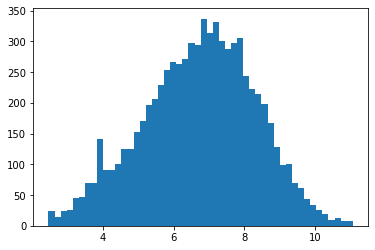

In [29]:
plt.hist(X_train['hemoglobin'], bins=50)

### Transformers

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
transform_columns = nan_columns + ['weight']
passthrough_columns = ['birthdate', 'sex_f', 'sex_m', 'smoker_no', 'smoker_yes']

ct = ColumnTransformer(transformers=[("PT", PowerTransformer(method='yeo-johnson', standardize=True), transform_columns)], remainder='passthrough')
X_train = pd.DataFrame(ct.fit_transform(X_train), columns=transform_columns + passthrough_columns)
X_train.head()

,leukocyty,hemoglobin,trombocyty,alt,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty,weight,birthdate,sex_f,sex_m,smoker_no,smoker_yes
0,-1.080178,0.697271,-0.865939,1.344219,0.270980,-0.043097,0.149793,0.662036,1.544223,0.410014,1.189197,0.484199,1977.0,1.0,0.0,1.0,0.0
1,-0.028083,0.428908,0.295784,-0.752937,-0.144953,0.098783,-0.554348,1.733431,-0.328181,-0.210306,-0.873770,0.025902,1960.0,0.0,1.0,1.0,0.0
2,-0.993968,-1.446010,-0.905146,1.012503,0.735934,-1.031662,-0.315068,0.245686,1.016888,0.443234,0.791369,-0.115481,1924.0,0.0,1.0,1.0,0.0
3,-2.545150,0.184585,-0.071387,-1.327212,-0.042275,0.820068,1.112807,0.316046,0.000270,-0.188105,0.379778,0.668620,2019.0,1.0,0.0,1.0,0.0
4,1.697070,1.840547,1.658703,1.418659,0.160881,-1.773735,-0.589852,-1.922866,-1.278039,-0.550294,1.244021,1.075104,1921.0,0.0,1.0,0.0,1.0


(array([ 26.,  26.,  23.,  52.,  55.,  80.,  81., 159., 100., 103., 136.,
        125., 167., 173., 205., 212., 244., 259., 274., 269., 277., 290.,
        306., 319., 312., 322., 293., 279., 286., 294., 221., 221., 211.,
        199., 155., 130., 113.,  75.,  87.,  68.,  51.,  41.,  31.,  24.,
         19.,  11.,  12.,  10.,   5.,   7.]),
 array([-2.48705872, -2.3786178 , -2.27017688, -2.16173596, -2.05329504,
        -1.94485412, -1.8364132 , -1.72797228, -1.61953136, -1.51109044,
        -1.40264952, -1.2942086 , -1.18576769, -1.07732677, -0.96888585,
        -0.86044493, -0.75200401, -0.64356309, -0.53512217, -0.42668125,
        -0.31824033, -0.20979941, -0.10135849,  0.00708243,  0.11552335,
         0.22396427,  0.33240519,  0.44084611,  0.54928703,  0.65772795,
         0.76616887,  0.87460979,  0.98305071,  1.09149163,  1.19993255,
         1.30837347,  1.41681439,  1.52525531,  1.63369623,  1.74213715,
         1.85057807,  1.95901899,  2.06745991,  2.17590083,  2.28434175,
 

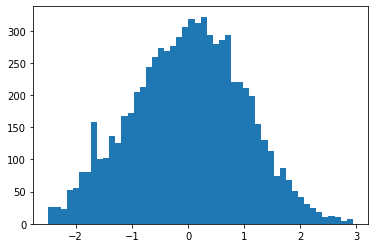

In [31]:
plt.hist(X_train['hemoglobin'], bins=50)

### Scaling

In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_train.head()

,leukocyty,hemoglobin,trombocyty,alt,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty,weight,birthdate,sex_f,sex_m,smoker_no,smoker_yes
0,0.304771,0.587293,0.336650,0.777203,0.557920,0.517956,0.539036,0.602728,0.784855,0.584428,0.717350,0.607722,0.620690,1.0,0.0,1.0,0.0
1,0.498652,0.537798,0.551841,0.397338,0.482855,0.555100,0.413388,0.791569,0.438711,0.472348,0.344802,0.526817,0.474138,0.0,1.0,1.0,0.0
2,0.320658,0.192003,0.329388,0.717119,0.641833,0.259151,0.456086,0.529343,0.687368,0.590431,0.645507,0.501859,0.163793,0.0,1.0,1.0,0.0
3,0.034805,0.492737,0.483829,0.293317,0.501385,0.743932,0.710878,0.541744,0.499430,0.476359,0.571178,0.640279,0.982759,1.0,0.0,1.0,0.0
4,0.816564,0.798150,0.804301,0.790687,0.538050,0.064877,0.407053,0.147119,0.263114,0.410918,0.727250,0.712037,0.137931,0.0,1.0,0.0,1.0


In [33]:
X_train.describe()

,leukocyty,hemoglobin,trombocyty,alt,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty,weight,birthdate,sex_f,sex_m,smoker_no,smoker_yes
count,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000
mean,0.503827,0.458694,0.497052,0.533720,0.509015,0.529239,0.512307,0.486039,0.499380,0.510346,0.502595,0.522245,0.501213,0.512234,0.487766,0.594246,0.405754
std,0.184293,0.184445,0.185247,0.181146,0.180487,0.261817,0.178454,0.176270,0.184879,0.180694,0.180600,0.176546,0.289103,0.499884,0.499884,0.491070,0.491070
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.379419,0.331765,0.368541,0.411577,0.385923,0.292972,0.377957,0.347505,0.375273,0.385120,0.377894,0.402614,0.250000,0.000000,0.000000,0.000000,0.000000
50%,0.504190,0.463931,0.498186,0.532309,0.510350,0.580500,0.521870,0.496821,0.499864,0.510720,0.504141,0.525575,0.500000,1.000000,0.000000,1.000000,0.000000
75%,0.630585,0.588339,0.624018,0.656992,0.634172,0.769012,0.645815,0.623282,0.625831,0.635491,0.627420,0.643873,0.750000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


(array([ 26.,  26.,  23.,  52.,  55.,  80.,  81., 159., 100., 103., 136.,
        125., 167., 173., 205., 212., 244., 259., 274., 269., 277., 290.,
        306., 319., 312., 322., 293., 279., 286., 294., 221., 221., 211.,
        199., 155., 130., 113.,  75.,  87.,  68.,  51.,  41.,  31.,  24.,
         19.,  11.,  12.,  10.,   5.,   7.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

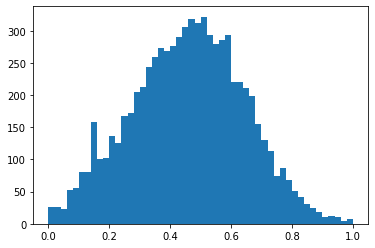

In [34]:
plt.hist(X_train['hemoglobin'], bins=50)

## 3. Výber atribútov pre strojové učenie

In [35]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [37]:
selector = SelectKBest(mutual_info_regression, k=2)
n = 5 ##overene s vyssim poctom testov, aktualne nastavene nizsie pre rychlejsi beh
scores = pd.Series((0 for col in X_train.columns), index=X_train.columns, dtype=float)
for i in range(n):
    selector.fit(X_train, y_train)
    mi_values = pd.Series(selector.scores_, index=X_train.columns)
    for col in mi_values.index:
        scores[col] += mi_values[col] / n
scores = scores.sort_values(ascending=False)
scores

hemoglobin    0.085278
hematokrit    0.070594
alp           0.013314
trombocyty    0.006175
birthdate     0.005136
sex_m         0.004535
sex_f         0.004287
erytrocyty    0.003653
smoker_yes    0.003308
etytr         0.002826
smoker_no     0.002595
er-cv         0.001898
ast           0.000534
leukocyty     0.000352
weight        0.000207
alt           0.000107
hbver         0.000000
dtype: float64

In [38]:
scores.index[0:2] ## 2 best

Index(['hemoglobin', 'hematokrit'], dtype='object')

In [39]:
X_best = SelectKBest(mutual_info_regression, k=2).fit_transform(X_train, y_train)
pd.DataFrame(X_best)

,0,1
0,0.587293,0.539036
1,0.537798,0.413388
2,0.192003,0.456086
3,0.492737,0.710878
4,0.798150,0.407053
...,...,...
7433,0.076169,0.587991
7434,0.272858,0.155604
7435,0.268937,0.283957
7436,0.902993,0.324011


## 4. Replikovateľnosť predspracovania

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
class PowTransformer():
    def __init__(self):
        

In [ ]:
ppl = Pipeline([
    ('prve', PrvyProcessor(parameter, parameter2)),
    ('druhe', FessTransformer(ano)),
    ('tretie', JaNevjemUs())
])